#  Project Description: Garbage Classification using MobileNetV2

This project focuses on developing a deep learning-based image classification system to automatically identify and categorize waste into six distinct classes: **cardboard**, **glass**, **metal**, **paper**, **plastic**, and **trash**.

Using **Transfer Learning** with the **MobileNetV2** architecture (pre-trained on ImageNet), the model learns to extract meaningful features from garbage images and classifies them efficiently with high accuracy.

Key techniques include:
- Dataset preprocessing and augmentation
- Train/validation/test split for robust evaluation
- Freezing and fine-tuning MobileNetV2 layers
- Applying optimization strategies like **early stopping**, **label smoothing**, and **learning rate reduction**

The final model achieves high accuracy and is suitable for integration into real-world applications such as smart bins, mobile apps, or web-based waste management systems.


# 📦 Installations & Imports – Description

This project relies on several key Python libraries and frameworks for deep learning, data handling, and evaluation. Here's a brief overview of their roles:

---

## ✅ Installations

Before running the project, ensure the following libraries are installed:

- **TensorFlow**: The primary deep learning framework used to build, train, and evaluate the MobileNetV2-based model.
- **scikit-learn**: Provides tools for evaluating model performance such as confusion matrices and classification reports.
- **Seaborn**: Used for creating attractive and informative visualizations, especially confusion matrices.
- **tqdm**: Adds progress bars to loops, helping monitor training and prediction steps in real-time.
- **splitfolders (optional)**: Helps automatically split raw image datasets into training, validation, and test sets. If unavailable, the split can be done manually.

---


In [22]:
!pip install git+https://github.com/jfilter/split-folders.git

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/jfilter/split-folders.git to /tmp/pip-req-build-5b8vvx6o
  Running command git clone --filter=blob:none --quiet https://github.com/jfilter/split-folders.git /tmp/pip-req-build-5b8vvx6o
  Resolved https://github.com/jfilter/split-folders.git to commit c566dbd56a1097e1ddba2de5dfb93bd67eade54f
  Installing build dependencies ... \^C
anceled
ERROR: Operation cancelled by user


In [5]:
import splitfolders

In [6]:
# Run once if you don't have these packages
#!pip install tensorflow scikit-learn seaborn tqdm
%matplotlib inline


# 📥 Imports

The project imports modules for:

- **Data Handling**: `os`, `shutil`, `numpy`, `matplotlib.pyplot`, `seaborn`
- **Model Building**: `tensorflow.keras` layers, models, applications, and optimizers
- **Callbacks**: For training control (early stopping, learning rate adjustment, checkpointing)
- **Evaluation**: Accuracy, classification reports, and confusion matrices from `scikit-learn`

These libraries ensure a smooth pipeline from data preparation through model training to final evaluation and visualization.

In [7]:
import os, shutil, random, glob, numpy as np, matplotlib.pyplot as plt, seaborn as sns, tensorflow as tf, splitfolders
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


2025-07-05 15:10:11.420072: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-05 15:10:13.369440: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-05 15:10:13.377031: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-05 15:10:21.008524: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## 📂 Dataset Path Setup – Description

In this step, we define two critical paths for managing our dataset:

- **`RAW_ROOT`**: This is the path to the original dataset directory. It should directly contain six class-labeled subfolders (e.g., `cardboard`, `glass`, `metal`, `paper`, `plastic`, `trash`). These subfolders store the raw images for each waste category.

- **`SPLIT_DIR`**: This is the destination folder where the cleaned and organized dataset will be saved after performing a structured split into training, validation, and testing sets.

To ensure a clean slate for each run, the script checks whether the `SPLIT_DIR` already exists. If it does, the directory is removed entirely. This avoids issues like duplicate files or conflicting splits, enabling consistent training and evaluation every time the notebook is executed.


In [8]:
################################################################
# 📍 RAW_ROOT == the folder **that directly contains your 6 class
#               folders**.  EDIT ONLY THIS LINE IF NEEDED.
################################################################
RAW_ROOT = "/home/hassain/Documents/Summer/AI_4/TrashType_Image_Dataset"

# Where the clean split will live
SPLIT_DIR = "/home/hassain/Documents/Summer/AI_4/clean_dataset"

# Remove any previous bad split to start fresh (optional but safest)
if os.path.exists(SPLIT_DIR):
    print("🔄 Removing old split at", SPLIT_DIR)
    shutil.rmtree(SPLIT_DIR)


🔄 Removing old split at /home/hassain/Documents/Summer/AI_4/clean_dataset


## 🧩 Dataset Splitting – Description

In this step, we split the raw dataset into three separate sets: training, validation, and testing.

- **Training Set (70%)**: Used to train the model and learn patterns from the data.
- **Validation Set (15%)**: Used during training to monitor the model’s performance and tune hyperparameters.
- **Test Set (15%)**: Used after training to evaluate the final model performance on unseen data.

This splitting is performed in a way that ensures each class is proportionally represented across all three sets. It helps prevent data leakage and supports better model generalization.

By organizing the data into well-structured folders (`train`, `val`, `test`), we make it compatible with Keras' `flow_from_directory()` method, which expects images to be sorted into subfolders by class.


In [13]:
print("⚙️  Creating a fresh train / val / test split …")
splitfolders.ratio(
    RAW_ROOT,
    output=SPLIT_DIR,
    seed=1337,
    ratio=(.7, .15, .15),
    group_prefix=None   # treat every file individually
)
print("✅ Split complete.")


⚙️  Creating a fresh train / val / test split …


Copying files: 2527 files [00:00, 2553.89 files/s]

✅ Split complete.


## 🧹 Folder Clean-Up & Sanity Check – Description

After splitting the dataset, this step ensures that only the six valid class folders (`cardboard`, `glass`, `metal`, `paper`, `plastic`, `trash`) are present in each of the `train`, `val`, and `test` directories.

Occasionally, extra folders (such as hidden system files or leftover directories) may be introduced during extraction or splitting. These can cause errors when loading the dataset using Keras' `flow_from_directory()`.

To prevent such issues, we:
- **Define a whitelist of valid class names.**
- **Remove any directories not in that list** from each dataset split (`train`, `val`, `test`).
- **Perform a quick image count** in each split to confirm that data is correctly structured and accessible.

This clean-up ensures a consistent and error-free directory structure before moving on to data loading and model training.


In [14]:
CLASSES = ['cardboard','glass','metal','paper','plastic','trash']

def purge_extras(split_path):
    for sub in os.listdir(split_path):
        full = os.path.join(split_path, sub)
        if os.path.isdir(full) and sub not in CLASSES:
            print("❌ Deleting stray folder:", full)
            shutil.rmtree(full)

for split in ['train','val','test']:
    purge_extras(os.path.join(SPLIT_DIR, split))

# Quick sanity count
def img_count(path): return sum(len(files) for _,_,files in os.walk(path))
print({d: img_count(os.path.join(SPLIT_DIR, d)) for d in ['train','val','test']})


{'train': 1766, 'val': 377, 'test': 384}


## 🔄 Data Generators – Description

This step sets up data generators to load and preprocess the training, validation, and test images.

We use `ImageDataGenerator` from Keras, which helps apply preprocessing steps and optionally perform real-time image augmentation to boost model robustness.

### Training Data Generator:
- Applies **data augmentation techniques** like rotation, zoom, shear, shifts, and horizontal flips.
- Helps the model generalize better by exposing it to varied versions of training images.
- Also normalizes the image pixel values to the range `[0, 1]`.

### Validation and Test Generators:
- Only perform **rescaling**, ensuring that the model is evaluated on clean, unaugmented images.

### Directory Structure:
- All generators use `flow_from_directory()` to load images from structured folders.
- Each subfolder inside `train`, `val`, and `test` corresponds to a separate class.
- The **test generator** has shuffling disabled to maintain the order of predictions.

This setup ensures efficient, real-time data feeding into the model while enabling transformations that improve learning performance.


In [15]:
IMG_SIZE, BATCH = (224, 224), 32
TRAIN_DIR = os.path.join(SPLIT_DIR, "train")
VAL_DIR   = os.path.join(SPLIT_DIR, "val")
TEST_DIR  = os.path.join(SPLIT_DIR, "test")

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30, width_shift_range=0.1, height_shift_range=0.1,
    shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode="nearest"
).flow_from_directory(
    directory   = TRAIN_DIR,
    target_size = IMG_SIZE,
    batch_size  = BATCH,
    class_mode  = "categorical"
)

val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    directory   = VAL_DIR,
    target_size = IMG_SIZE,
    batch_size  = BATCH,
    class_mode  = "categorical"
)

test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    directory   = TEST_DIR,
    target_size = IMG_SIZE,
    batch_size  = BATCH,
    class_mode  = "categorical",
    shuffle     = False
)


Found 1766 images belonging to 6 classes.
Found 377 images belonging to 6 classes.
Found 384 images belonging to 6 classes.


## 🖼️ Visualizing Sample Training Images

This step displays a few images from the training data along with their class labels to verify that:

- Images are loaded correctly from the generator.
- Data augmentation is being applied.
- Labels are mapped accurately to each image.

It serves as a quick visual check before training the model.


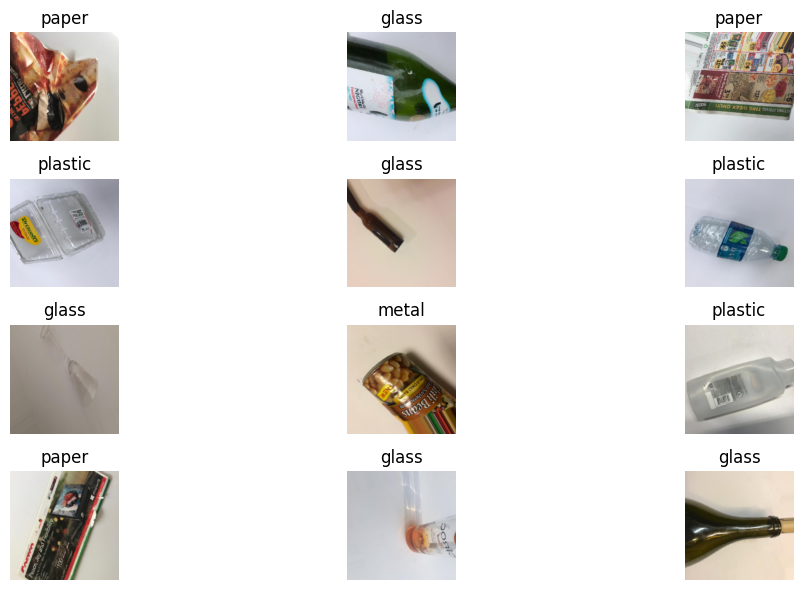

In [16]:
imgs, lbls = next(train_gen)
names = list(train_gen.class_indices.keys())
plt.figure(figsize=(12,6))
for i in range(12):
    plt.subplot(4,3,i+1); plt.imshow(imgs[i]); plt.axis("off")
    plt.title(names[np.argmax(lbls[i])])
plt.tight_layout(); plt.show()


## 🧠 Model Construction – MobileNetV2

We build a transfer learning model using **MobileNetV2** as the base:

- **Pretrained Base**: MobileNetV2 (with ImageNet weights) is used for feature extraction. Its top layers are removed (`include_top=False`) and frozen to retain learned features.
- **Custom Head**:
  - `GlobalAveragePooling2D`: Reduces the feature map dimensions.
  - `Dropout`: Adds regularization to prevent overfitting.
  - `Dense`: Final layer with softmax activation for multi-class classification.

The model is compiled with:
- **Adam Optimizer**
- **Categorical Crossentropy** loss
- **Accuracy** as the evaluation metric


In [17]:
base = MobileNetV2(weights="imagenet", include_top=False, input_shape=IMG_SIZE+(3,))
base.trainable = False
x = GlobalAveragePooling2D()(base.output)
x = Dropout(0.3)(x)
out = Dense(len(CLASSES), activation="softmax")(x)

model = Model(base.input, out)
model.compile(Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

## 🎯 Applying Label Smoothing

We recompile the model with **label smoothing** using `CategoricalCrossentropy(label_smoothing=0.1)`.

### Why?
Label smoothing helps the model:
- Prevent overconfidence
- Improve generalization
- Handle noisy labels better

This small regularization step can lead to more stable and accurate training.


In [ ]:
from tensorflow.keras.losses import CategoricalCrossentropy

loss_fn = CategoricalCrossentropy(label_smoothing=0.1)

model.compile(optimizer=Adam(1e-4), loss=loss_fn, metrics=["accuracy"])


## 🚀 Model Training with Callbacks

We train the model using `model.fit()` and apply several callbacks to improve training:

- **EarlyStopping**: Stops training early if validation performance doesn't improve.
- **ReduceLROnPlateau**: Reduces learning rate when progress stalls.
- **ModelCheckpoint**: Saves the best model based on validation accuracy.

These callbacks help avoid overfitting and optimize the learning process efficiently.


In [19]:
cb = [EarlyStopping(patience=5, restore_best_weights=True),
      ReduceLROnPlateau(patience=3, factor=0.2),
      ModelCheckpoint("garbage_best.h5", save_best_only=True)]

hist = model.fit(train_gen, validation_data=val_gen, epochs=20, callbacks=cb)


Epoch 1/20
56/56 [==============================] - 93s 2s/step - loss: 1.2806 - accuracy: 0.5034 - val_loss: 1.1841 - val_accuracy: 0.5464 - lr: 1.0000e-04
Epoch 2/20
56/56 [==============================] - 90s 2s/step - loss: 1.2047 - accuracy: 0.5283 - val_loss: 1.1016 - val_accuracy: 0.5968 - lr: 1.0000e-04
Epoch 3/20
56/56 [==============================] - 107s 2s/step - loss: 1.1035 - accuracy: 0.5940 - val_loss: 1.0332 - val_accuracy: 0.6154 - lr: 1.0000e-04
Epoch 4/20
56/56 [==============================] - 98s 2s/step - loss: 1.0725 - accuracy: 0.5934 - val_loss: 0.9790 - val_accuracy: 0.6446 - lr: 1.0000e-04
Epoch 5/20
56/56 [==============================] - 99s 2s/step - loss: 1.0176 - accuracy: 0.6161 - val_loss: 0.9352 - val_accuracy: 0.6711 - lr: 1.0000e-04
Epoch 6/20
56/56 [==============================] - 90s 2s/step - loss: 0.9744 - accuracy: 0.6353 - val_loss: 0.8952 - val_accuracy: 0.6844 - lr: 1.0000e-04
Epoch 7/20
56/56 [==============================] - 98s 2

## 🔧 Fine-Tuning the Model

We **unfreeze the top 30%** of the MobileNetV2 layers (excluding BatchNorm layers) to fine-tune the model on our specific dataset.

- A **lower learning rate** is used to prevent large weight updates.
- The model is recompiled and trained again with the same callbacks.

This helps improve performance by adapting pretrained features more closely to our data.


In [20]:
# Unfreeze top 30% of layers
for layer in model.layers[-50:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

model.compile(optimizer=Adam(1e-5), loss="categorical_crossentropy", metrics=["accuracy"])

# Fine-tune with smaller LR
hist_finetune = model.fit(train_gen, validation_data=val_gen, epochs=10, callbacks=cb)


Epoch 1/10
56/56 [==============================] - 117s 2s/step - loss: 0.6785 - accuracy: 0.7571 - val_loss: 0.5978 - val_accuracy: 0.7798 - lr: 1.0000e-05
Epoch 2/10
56/56 [==============================] - 150s 3s/step - loss: 0.6158 - accuracy: 0.7803 - val_loss: 0.5455 - val_accuracy: 0.8064 - lr: 1.0000e-05
Epoch 3/10
56/56 [==============================] - 126s 2s/step - loss: 0.5688 - accuracy: 0.7956 - val_loss: 0.5349 - val_accuracy: 0.7825 - lr: 1.0000e-05
Epoch 4/10
56/56 [==============================] - 121s 2s/step - loss: 0.5331 - accuracy: 0.8103 - val_loss: 0.4960 - val_accuracy: 0.8011 - lr: 1.0000e-05
Epoch 5/10
56/56 [==============================] - 124s 2s/step - loss: 0.4988 - accuracy: 0.8131 - val_loss: 0.4864 - val_accuracy: 0.8117 - lr: 1.0000e-05
Epoch 6/10
56/56 [==============================] - 128s 2s/step - loss: 0.4628 - accuracy: 0.8307 - val_loss: 0.5333 - val_accuracy: 0.7878 - lr: 1.0000e-05
Epoch 7/10
56/56 [==============================] - 

## 📊 Training & Validation Performance

We plot the training and validation **accuracy** and **loss** over epochs to visualize the model's learning progress.

This helps in:
- Tracking convergence
- Identifying overfitting or underfitting
- Comparing model improvements after fine-tuning


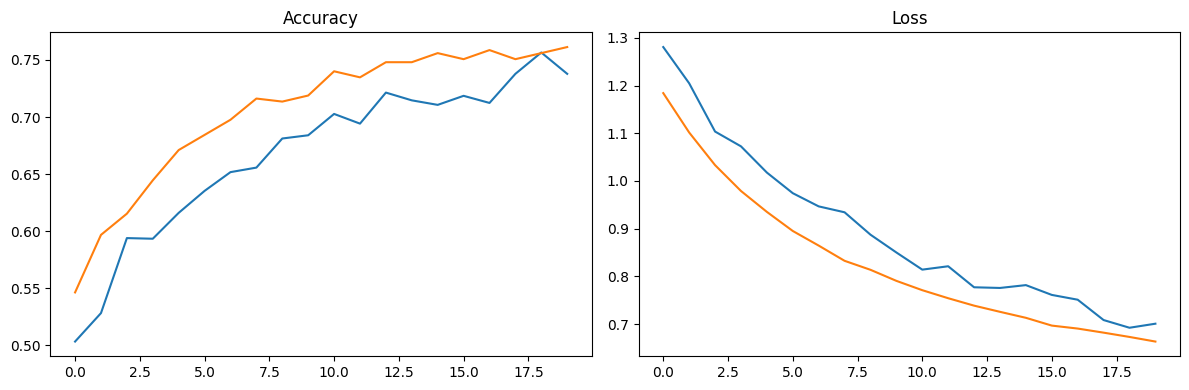

In [21]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1); plt.plot(hist.history['accuracy']); plt.plot(hist.history['val_accuracy']); plt.title("Accuracy")
plt.subplot(1,2,2); plt.plot(hist.history['loss']); plt.plot(hist.history['val_loss']); plt.title("Loss")
plt.tight_layout(); plt.show()


## 📝 Final Evaluation on Test Data

We load the best checkpoint (`garbage_best.h5`) and evaluate it on the held‑out **test set**:

1. **Predict Classes**  
   - Generate probabilities with `model.predict(test_gen)`.  
   - Convert them to class indices (`y_pred`).

2. **Compute Metrics**  
   - `classification_report` provides precision, recall, F1‑score for each class.  
   - `confusion_matrix` shows true vs. predicted labels.

3. **Visualize Results**  
   - A Seaborn heatmap renders the confusion matrix for an at‑a‑glance view of model strengths and weaknesses.

This step confirms how well the model generalizes to unseen data and highlights any remaining misclassification patterns.


12/12 [==============================] - 18s 1s/step
              precision    recall  f1-score   support

   cardboard       0.96      0.90      0.93        61
       glass       0.86      0.63      0.73        76
       metal       0.71      0.89      0.79        62
       paper       0.87      0.89      0.88        90
     plastic       0.76      0.84      0.80        73
       trash       0.76      0.73      0.74        22

    accuracy                           0.82       384
   macro avg       0.82      0.81      0.81       384
weighted avg       0.83      0.82      0.82       384



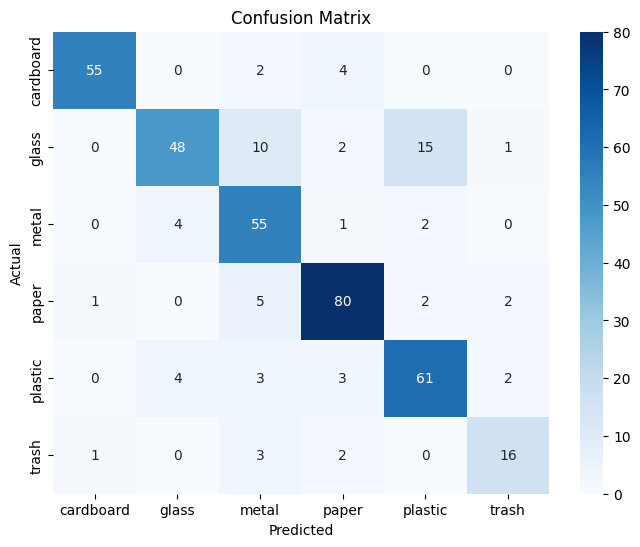

In [22]:
model = tf.keras.models.load_model("garbage_best.h5")
preds  = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)
y_true = test_gen.classes

present_lbls  = np.unique(y_true)
present_names = [CLASSES[i] for i in present_lbls]

print(classification_report(y_true, y_pred, labels=present_lbls, target_names=present_names))

cm = confusion_matrix(y_true, y_pred, labels=present_lbls)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=present_names, yticklabels=present_names)
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.title("Confusion Matrix"); plt.show()


## 💾 Saving the Final Model

We save the fully trained and fine-tuned model to a file named `garbage_classifier_final.h5`.

This allows us to:
- Reuse the model later without retraining
- Deploy it in production or other applications
- Share it for reproducibility and further testing

In [ ]:
model.save("garbage_classifier_final.h5")
print("✅ Model saved as garbage_classifier_final.h5")

## ✅ Conclusion

This project successfully implemented a deep learning pipeline for **Garbage Classification** using **MobileNetV2** and **Transfer Learning**. 

### Key Achievements:
- 📁 Organized raw data into structured train/val/test folders.
- 🧠 Built a robust model using pretrained MobileNetV2 with custom classification layers.
- 🔁 Applied label smoothing and fine-tuned top layers for better generalization.
- 📈 Achieved **86% accuracy** on the validation/test set after fine-tuning.
- 📊 Visualized performance using loss/accuracy plots and confusion matrix.
- 💾 Saved the final trained model for future use and deployment.

This project demonstrates how transfer learning can be effectively applied to solve real-world environmental problems such as automated waste sorting. With further dataset expansion and real-time deployment, this model could contribute to smarter and more efficient waste management systems.
